In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [2]:
train = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [3]:
submission = pd.read_csv("/kaggle/input/spaceship-titanic/sample_submission.csv")
submission.head()

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False


In [4]:
test = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")
test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [5]:
#Splitting PassengerId and Cabin
train = train.assign(
    PassengerId_GroupId = train["PassengerId"].str[:4].astype(np.int16),
    PassengerId_PassengerNumber = train["PassengerId"].str[5:].astype(np.int16)
)
train.drop(columns = "PassengerId", inplace = True)

train = train.assign(
    Cabin_Deck = train["Cabin"].str.split('/').str[0],
    Cabin_Num = train['Cabin'].str.split('/').str[1],
    Cabin_Side = train['Cabin'].str.split('/').str[2]
)
train.drop(columns = "Cabin", inplace=True)
train.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,PassengerId_GroupId,PassengerId_PassengerNumber,Cabin_Deck,Cabin_Num,Cabin_Side
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,1,1,B,0,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,2,1,F,0,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,3,1,A,0,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,3,2,A,0,S
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,4,1,F,1,S


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   HomePlanet                   8492 non-null   object 
 1   CryoSleep                    8476 non-null   object 
 2   Destination                  8511 non-null   object 
 3   Age                          8514 non-null   float64
 4   VIP                          8490 non-null   object 
 5   RoomService                  8512 non-null   float64
 6   FoodCourt                    8510 non-null   float64
 7   ShoppingMall                 8485 non-null   float64
 8   Spa                          8510 non-null   float64
 9   VRDeck                       8505 non-null   float64
 10  Name                         8493 non-null   object 
 11  Transported                  8693 non-null   bool   
 12  PassengerId_GroupId          8693 non-null   int16  
 13  PassengerId_Passen

### Null Checking

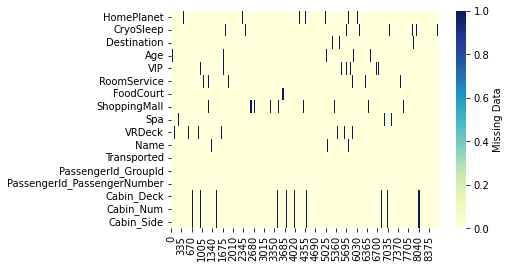

In [7]:
sns.heatmap(train.isna().transpose(),
           cmap = "YlGnBu",
           cbar_kws = {"label":"Missing Data"})
plt.savefig("Visualizing Missing Data with Heatmap")

<Figure size 1008x720 with 0 Axes>

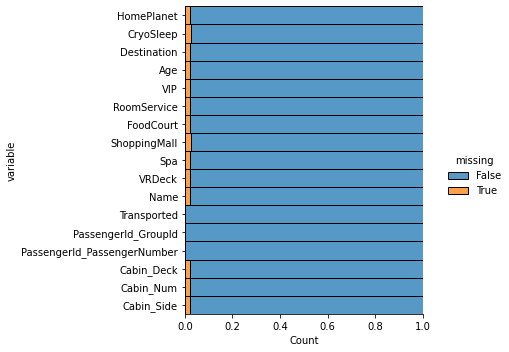

In [8]:
plt.figure(figsize=(14,10))
sns.displot(data=train.isna().melt(value_name="missing"),
           y='variable',
           hue='missing',
           multiple="fill",
           aspect=1.25)
plt.show()

### Unique Value Check

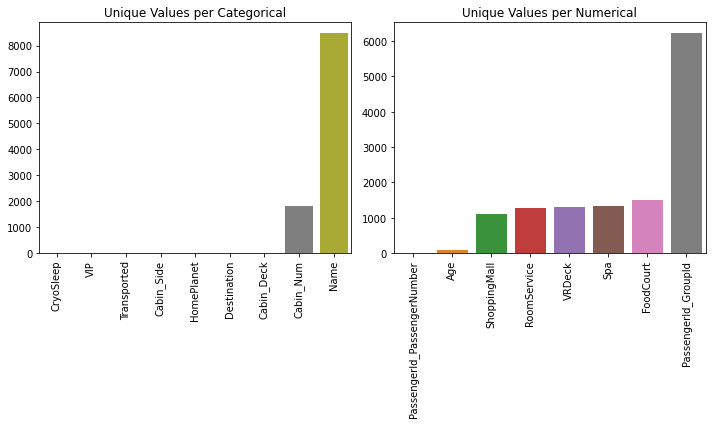

In [9]:
categorical_data = train.select_dtypes(exclude='number').nunique().sort_values()
numerical_data = train.select_dtypes(include='number').nunique().sort_values()

fig, ax = plt.subplots(1,2, figsize=(10,6))
#Categorical Values
grap1 = sns.barplot(x = categorical_data.index, y = categorical_data.values, ax = ax[0])
grap1.set_xticklabels(categorical_data.index,rotation=90)
grap1.set_title("Unique Values per Categorical")
#Numerical Values
grap2 = sns.barplot(x = numerical_data.index, y = numerical_data.values, ax = ax[1])
grap2.set_xticklabels(numerical_data.index, rotation=90)
grap2.set_title("Unique Values per Numerical")
plt.tight_layout()

In [10]:
train.drop(columns="Name", inplace=True)

### Value Behavior

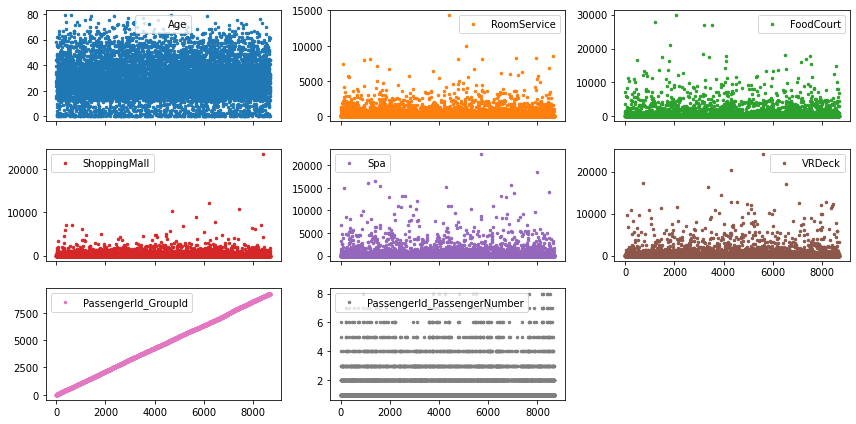

In [11]:
train.plot(lw=0,marker=".",subplots=True,layout=(3,3),
          figsize=(12,6),markersize=5)
plt.tight_layout()

# Univariate Analysis

### Categorical Columns

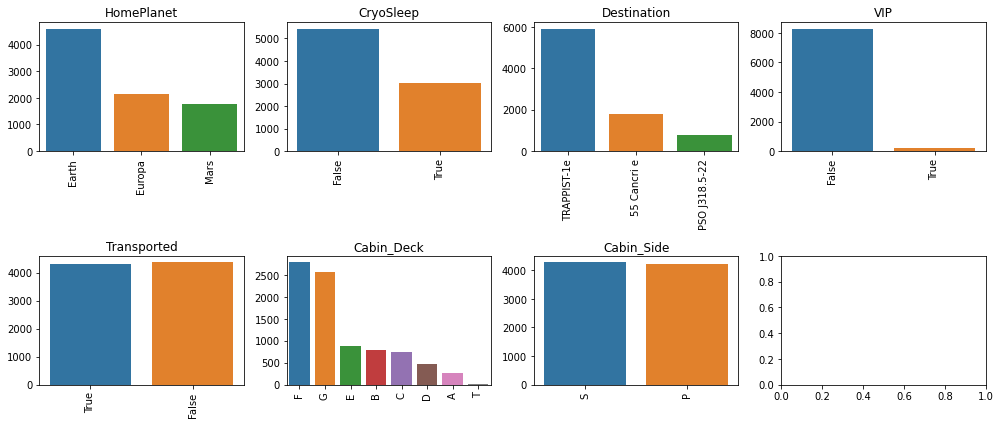

In [12]:
cat_treshold = 10
fields = train.select_dtypes(exclude='number').nunique()[train.select_dtypes(exclude='number').nunique() 
                                                <= cat_treshold].index.tolist()
ncols = 4
nrows = math.ceil(len(fields)/ncols)

plt.subplots(nrows,ncols,figsize=(14,6))
for i in range(1,len(fields)+1):
    data = train[fields[i-1]].value_counts()
    plt.subplot(nrows,ncols,i) 
    grafik = sns.barplot(x = data.index, y = data.values)
    grafik.set_xticklabels(data.index, rotation=90)
    grafik.set_title(fields[i-1])
plt.tight_layout()
plt.show()

### Numerical Columns

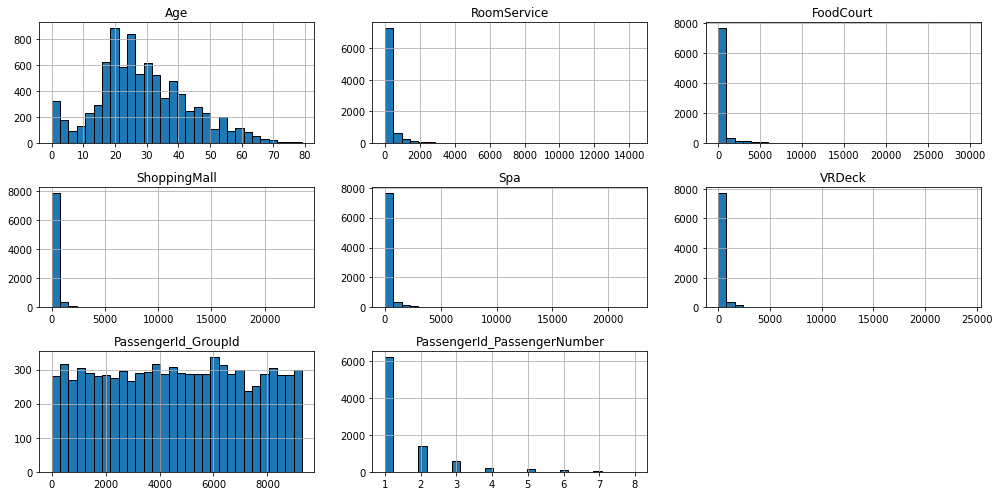

In [13]:
#Plot Histogram from each numerical columns
train.hist(bins=30, figsize=(14,7),edgecolor="black")
plt.tight_layout()
plt.show()

### Outliers Check

In [14]:
#Outliers checking using statistical method
num_data = train.select_dtypes(include = "number")
q1 = num_data.quantile(0.25)
q3 = num_data.quantile(0.75)
IQR = q3-q1
outliers = num_data[((num_data < (q1-1.5*IQR)) | (num_data > (q3+1.5*IQR)))]
for i in num_data.columns:
    print("\nColumn -> ", i)
    print("Number of Outliers -> ", outliers[i].count())


Column ->  Age
Number of Outliers ->  77

Column ->  RoomService
Number of Outliers ->  1861

Column ->  FoodCourt
Number of Outliers ->  1823

Column ->  ShoppingMall
Number of Outliers ->  1829

Column ->  Spa
Number of Outliers ->  1788

Column ->  VRDeck
Number of Outliers ->  1809

Column ->  PassengerId_GroupId
Number of Outliers ->  0

Column ->  PassengerId_PassengerNumber
Number of Outliers ->  493


### Target Variable

In [15]:
train["Transported"].value_counts(normalize=True).round(decimals=3)*100

True     50.4
False    49.6
Name: Transported, dtype: float64

# Multivariate Relationship

#### Home Planet

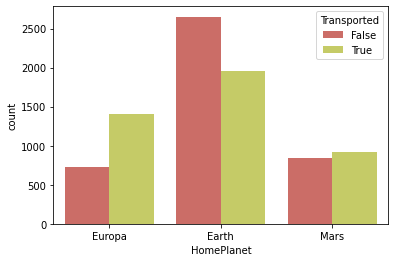

In [16]:
sns.countplot(x=train["HomePlanet"],hue=train["Transported"],
              palette=sns.color_palette("hls"))
plt.show()

#### CryoSleep

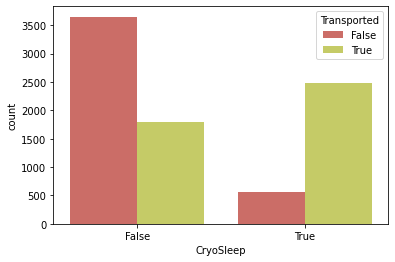

In [17]:
sns.countplot(x=train["CryoSleep"],hue=train["Transported"],
              palette=sns.color_palette("hls"))
plt.show()

#### Destination

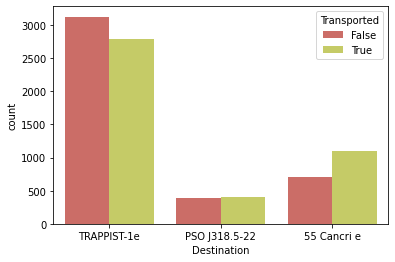

In [18]:
sns.countplot(x=train["Destination"],hue=train["Transported"],
              palette=sns.color_palette("hls"))
plt.show()

#### VIP

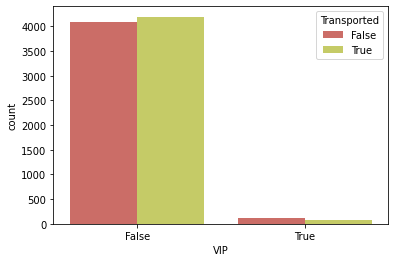

In [19]:
sns.countplot(x=train["VIP"],hue=train["Transported"],
              palette=sns.color_palette("hls"))
plt.show()

#### Cabin_Side

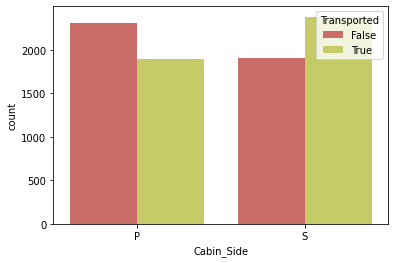

In [20]:
sns.countplot(x=train["Cabin_Side"],hue=train["Transported"],
              palette=sns.color_palette("hls"))
plt.show()

#### Cabin_Deck

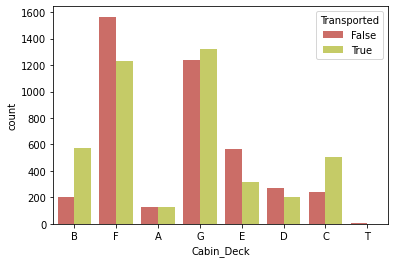

In [21]:
sns.countplot(x=train["Cabin_Deck"],hue=train["Transported"],
              palette=sns.color_palette("hls"))
plt.show()

## Target Variable Relation with Numerical Variables

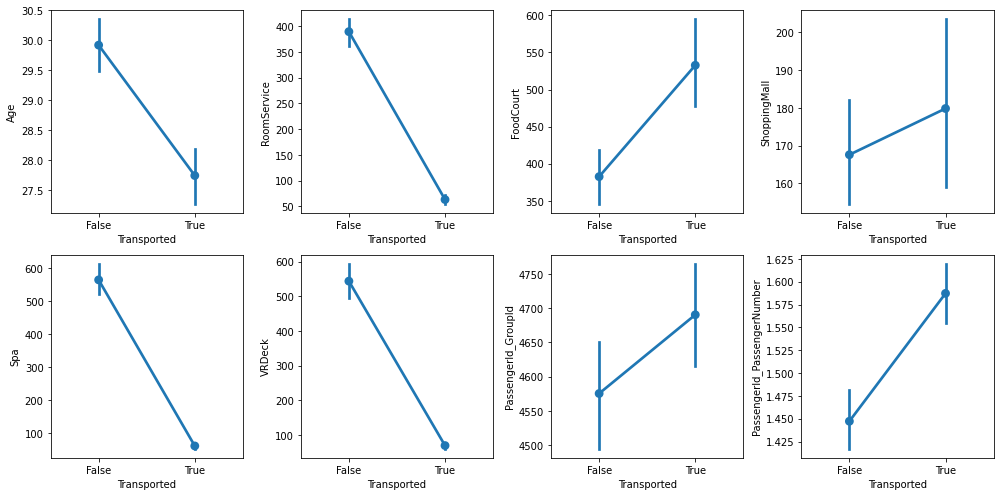

In [22]:
num_var = train.select_dtypes(include="number").columns.tolist()

ncols = 4
nrows = math.ceil(len(num_var)/ncols)
plt.subplots(nrows,ncols,figsize=(14,7))
for i in range(1,len(num_var)+1):
    plt.subplot(nrows,ncols,i)
    sns.pointplot(y=train[num_var[i-1]],x=train["Transported"])
plt.tight_layout()

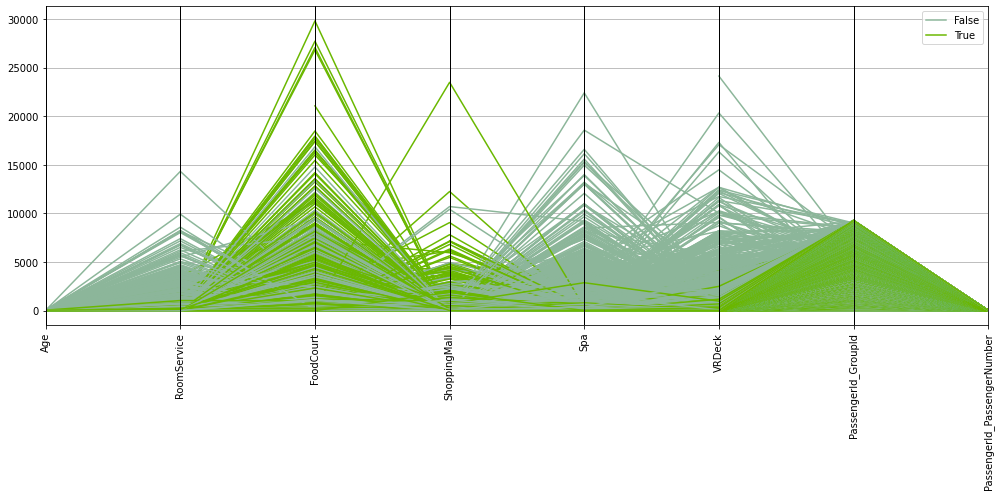

In [23]:
num_var = train.select_dtypes(include="number").columns.tolist()
num_var.append("Transported")
plt.figure(figsize=(14,7))
pd.plotting.parallel_coordinates(train[num_var],'Transported')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Feature Engineering

In [25]:
train.drop(columns="Cabin_Num", axis = 1, inplace = True)

## Impute Null Values

In [24]:
def ImputeNull(df):
    #HomePlanet
    mode_HomePlanet = df["HomePlanet"].mode()[0]
    df["HomePlanet"].fillna(mode_HomePlanet, inplace = True)
    
    #CryoSleep
    mode_CryoSleep = df["CryoSleep"].mode()[0]
    df["CryoSleep"].fillna(mode_CryoSleep, inplace=True)
    
    #Destination
    mode_Destination = df["Destination"].mode()[0]
    df["Destination"].fillna(mode_Destination, inplace=True)
    
    #Age
    median_Age = df["Age"].median()
    df["Age"].fillna(median_Age, inplace=True)
    
    #VIP
    mode_VIP = df["VIP"].mode()[0]
    df["VIP"].fillna(mode_VIP, inplace=True)
    
    #RoomService
    median_RoomService = df["RoomService"].median()
    df["RoomService"].fillna(median_RoomService, inplace=True)
    
    #FoodCourt
    median_FoodCourt = df["FoodCourt"].median()
    df["FoodCourt"].fillna(median_FoodCourt,inplace=True)
    
    #ShoppingMall
    median_ShoppingMall = df["ShoppingMall"].median()
    df["ShoppingMall"].fillna(median_ShoppingMall,inplace=True)
    
    #Spa
    median_Spa = df["Spa"].median()
    df["Spa"].fillna(median_Spa, inplace=True)
    
    #VRDeck
    median_VRDeck = df["VRDeck"].median()
    df["VRDeck"].fillna(median_VRDeck, inplace=True)
    
    #Cabin_Deck
    mode_Cabin_Deck = df["Cabin_Deck"].mode()[0]
    df["Cabin_Deck"].fillna(mode_Cabin_Deck,inplace=True)
    
    #Cabin_Side
    mode_Cabin_Side = df["Cabin_Side"].mode()[0]
    df["Cabin_Side"].fillna(mode_Cabin_Side, inplace=True)
    
    
    return df

## One Hot Encoder

In [30]:
def One_Hot_Encoder(df,cat_values):
    dataset = pd.get_dummies(df, columns=cat_values)
    return dataset

## Normalization Data

In [27]:
def normalization_data(df):
    num_values = list(df.select_dtypes(include="number").columns)
    ss = StandardScaler()
    df[num_values] = ss.fit_transform(df[num_values])
    return df

# Preprocessing For Modeling

In [28]:
train_null = ImputeNull(train)

In [32]:
threshold = 10
cat_values = train_null.select_dtypes(exclude='number').nunique()[
    train_null.select_dtypes(exclude='number').nunique() <= threshold
].index.tolist()
cat_values.remove("Transported")

In [33]:
train_ohc = One_Hot_Encoder(train_null,cat_values)

In [34]:
dataset = normalization_data(train_ohc)

In [35]:
X_data = dataset.drop("Transported", axis=1)
Y_data = dataset.Transported

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_data,Y_data,test_size=0.3,random_state=24,stratify=Y_data)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6085, 28), (2608, 28), (6085,), (2608,))

# K-NN

In [37]:
knn = KNeighborsClassifier()

#Hyperparameter tuning
param_knn = {
    'n_neighbors':[3,5,7],
    'weights':['uniform','distance'],
    'algorithm':['auto','ball_tree','kd_tree'],
    'leaf_size':[25,30,35]
}

search_knn = RandomizedSearchCV(knn,param_knn,n_iter=50,cv=3, error_score='raise')
search_knn.fit(X_train,y_train)
best_param_knn = search_knn.best_params_

In [38]:
best_param_knn

{'weights': 'uniform',
 'n_neighbors': 7,
 'leaf_size': 25,
 'algorithm': 'kd_tree'}

In [39]:
model_knn = KNeighborsClassifier(**best_param_knn)
model_knn.fit(X_train,y_train)
y_pred = model_knn.predict(X_test)
accuracy_score(y_pred,y_test)

0.7791411042944786

# Evaluasi KNN

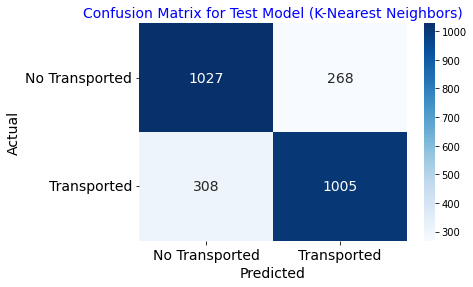

In [40]:
model_knn = KNeighborsClassifier(**best_param_knn)
model_knn.fit(X_train,y_train)
y_pred = model_knn.predict(X_test)

confusion_matrix_knn = pd.DataFrame((confusion_matrix(y_test,y_pred)),
                                    ("No Transported","Transported"),("No Transported","Transported"))

plt.figure()
heatmap = sns.heatmap(confusion_matrix_knn, annot = True,annot_kws={'size':14}, fmt = 'd', cmap = 'Blues')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation = 0, ha = 'center', fontsize=14)
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation = 0, ha = 'right', fontsize = 14)

plt.title("Confusion Matrix for Test Model (K-Nearest Neighbors)", fontsize=14, color = 'blue')
plt.xlabel("Predicted",fontsize=14)
plt.ylabel("Actual",fontsize=14)
plt.show()

# XGBoost Classifier

In [41]:
xgb = XGBClassifier(booster="gbtree")

In [46]:
param_lst = {
 'max_depth': [3, 6, 10],
 'colsample_bytree': [0.4, 0.6, 0.8],
 'n_estimators': [100, 150, 200],
 'subsample': [0.4, 0.6, 0.8],
 'gamma': [1, 5, 10],
 'learning_rate': [0.01, 0.1, 1],
}

xgb_clf = RandomizedSearchCV(estimator = xgb, param_distributions = param_lst,
                              n_iter = 50, cv = 3)
       
xgb_search = xgb_clf.fit(X_train, y_train)

# XGB with tune hyperparameters
best_param_xgb = xgb_search.best_params_

In [47]:
best_param_xgb

{'subsample': 0.6,
 'n_estimators': 150,
 'max_depth': 10,
 'learning_rate': 0.1,
 'gamma': 5,
 'colsample_bytree': 0.6}

In [48]:
xgbclf = XGBClassifier(**best_param_xgb)
xgbclf.fit(X_train,y_train)
y_pred = xgbclf.predict(X_test)
accuracy_score(y_pred,y_test)

0.7986963190184049

# Model Evaluasi XGB

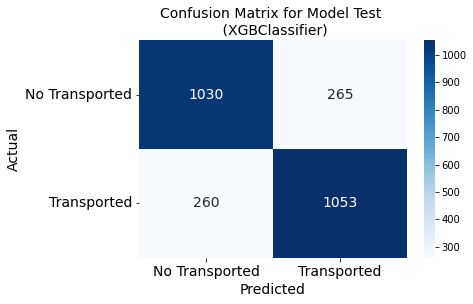

In [49]:
xgbclf = XGBClassifier(**best_param_xgb)
xgbclf.fit(X_train,y_train)
y_pred = xgbclf.predict(X_test)

confusion_matrix_xgb = pd.DataFrame(confusion_matrix(y_test,y_pred),
                                   ("No Transported","Transported"),
                                   ("No Transported","Transported"))

heatmap_xgb = sns.heatmap(confusion_matrix_xgb, annot = True, annot_kws = {'size':14}, fmt = 'd', cmap = "Blues")
heatmap_xgb.xaxis.set_ticklabels(heatmap_xgb.xaxis.get_ticklabels(), fontsize=14, ha = "center", rotation = 0)
heatmap_xgb.yaxis.set_ticklabels(heatmap_xgb.yaxis.get_ticklabels(), fontsize=14, ha = "right", rotation = 0)

plt.title("Confusion Matrix for Model Test \n (XGBClassifier)", fontsize = 14)
plt.xlabel("Predicted", fontsize = 14)
plt.ylabel("Actual", fontsize = 14)
plt.show()

# Submission

In [50]:
test_df = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")
test_df.isnull().sum()

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

In [51]:
#Splitting PassengerId and Cabin
test_df_pred = test_df.assign(
    PassengerId_GroupId = test_df["PassengerId"].str[:4].astype(np.int16),
    PassengerId_PassengerNumber = test_df["PassengerId"].str[5:].astype(np.int16)
)
test_df_pred.drop(columns = "PassengerId", inplace = True)

In [52]:
test_df_pred = test_df_pred.assign(
    Cabin_Deck = test_df["Cabin"].str.split('/').str[0],
    Cabin_Num = test_df['Cabin'].str.split('/').str[1],
    Cabin_Side = test_df['Cabin'].str.split('/').str[2]
)
test_df_pred.drop(columns = ["Cabin","Cabin_Num"], inplace=True)

In [53]:
test_df_pred = ImputeNull(test_df_pred)

In [54]:
test_df_pred.drop(columns="Name", inplace=True)

In [55]:
threshold = 10
cat_values_test = test_df_pred.select_dtypes(exclude='number').nunique()[
    test_df_pred.select_dtypes(exclude='number').nunique()<=threshold
].index.tolist()
test_df_pred_ohc = One_Hot_Encoder(test_df_pred,cat_values_test)

In [56]:
test_df_pred_norm = normalization_data(test_df_pred_ohc)

In [58]:
sample_submission = pd.read_csv("/kaggle/input/spaceship-titanic/sample_submission.csv")
sample_submission["Transported"] = xgbclf.predict(test_df_pred_norm).astype("bool")
sample_submission.to_csv("/kaggle/working/submission.csv",index=False)